In [1]:
%load_ext lab_black
%matplotlib inline

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
import theano.tensor as tt
import warnings

from scipy.special import softmax

warnings.simplefilter(action="ignore", category=FutureWarning)

sns.set(context="notebook", font_scale=1.2, rc={"figure.figsize": (12, 5)})
plt.style.use(["seaborn-colorblind", "seaborn-darkgrid"])

RANDOM_SEED = 8927
np.random.seed(286)

PREDICTORS = [
    "climat_affaires",
    "conf_menages",
    "prix_gazole",
    "inflation",
    "pib",
    "net_app",
    "chomage",
]
PARTIES = ["farleft", "left", "green", "center", "right", "farright", "other"]
PARTIES_INT = [f"{p}_int" for p in PARTIES]

# Helper functions
def stdz(series: pd.Series):
    """Standardize the given pandas Series"""
    return (series - series.mean()) / series.std()


def prior_pred_checks(pp_sample: np.array):
    """Draw prior predictive checks for results of each party"""
    fig, axes = plt.subplots(2, 4, figsize=(17, 8))
    i = 0
    for row in axes:
        for col in row:
            try:
                az.plot_kde(pp_sample[:, i], ax=col)
                col.axvline(pp_sample[:, i].mean(), linewidth=1.2, color="k", alpha=0.4)
                col.set_xlabel("Prior results")
                col.set_ylabel("Density")
                i += 1
            # it's an 8-spot grid but there are only 7 parties
            except IndexError:
                continue

Let's load the data, standardize the predictors and transform the election results into integers:

In [2]:
d = pd.read_json("full_funds.json")

for p in PREDICTORS:
    d[f"{p}_std"] = stdz(d[p])
d[PARTIES_INT] = (d[PARTIES] * 100).astype(int)
d.head()

,departement,date,climat_affaires,conf_menages,prix_gazole,inflation,pib,net_app,chomage,election,...,pib_std,net_app_std,chomage_std,farleft_int,left_int,green_int,center_int,right_int,farright_int,other_int
0,ain,1992-03-22,95.5,102,0.54,3.2,0.546012,-20.48,5.0,dep1992,...,0.229333,-0.647461,-1.790003,482,1389,741,2488,2064,1259,1577
1,ain,1993-03-21,76.7,99,0.54,2.4,-0.213516,-28.59,6.3,leg1993,...,-1.095113,-1.026878,-1.150627,647,1182,553,2560,2274,1483,1301
2,ain,1994-03-20,93.5,100,0.60,2.1,0.225626,-10.54,7.4,dep1994,...,-0.329348,-0.182428,-0.609616,698,1216,548,2617,1476,1149,2296
3,ain,1994-06-12,103.0,104,0.60,2.1,0.658377,-8.29,7.6,euro1994,...,0.425272,-0.077165,-0.511251,675,1339,552,2548,2656,1211,1019
4,ain,1995-04-23,107.7,107,0.59,1.6,0.480469,-5.03,6.9,pres1995,...,0.115041,0.075351,-0.855530,1104,2050,391,1980,1923,1986,566


In [3]:
d[
    [
        "climat_affaires_std",
        "conf_menages_std",
        "prix_gazole_std",
        "inflation_std",
        "pib_std",
        "net_app_std",
        "chomage_std",
    ]
].describe().round(2)

,climat_affaires_std,conf_menages_std,prix_gazole_std,inflation_std,pib_std,net_app_std,chomage_std
count,1889.00,1889.00,1889.00,1889.00,1889.00,1889.00,1889.00
mean,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.61,-1.74,-1.23,-2.14,-3.59,-2.36,-2.43
25%,-0.52,-0.33,-0.74,-0.26,-0.27,-0.66,-0.71
50%,0.24,-0.11,-0.26,0.01,0.23,-0.08,-0.07
75%,0.68,0.65,0.74,0.55,0.66,0.54,0.52
max,1.28,2.39,2.19,2.02,1.15,1.92,3.42


Note that these data only contain elections where all 6 parties were competing. We threw out the other elections. For our first analysis, this should be good enough. But our future analysis should include the other elections to improve our inference.

Before anything, let's think about the possible causal model. This is the DAG we're working with (generated with [dagitty](http://dagitty.net/dags.html#)):
![Fundamentals DAG](dagitty-model.png)

#### Causal effect identification
- No adjustment is necessary to estimate the *total* effect of `Rural` on `Results`.

- Minimal sufficient adjustment sets for estimating the *direct* effect of Rural on Results: condition on `GDP` and `Unemployment`.

- There are no instruments or conditional instruments in this DAG.

#### Testable implications
The model implies the following conditional independencies:
- GDP ⊥ Rural
- Pop_PR ⊥ Rural | GDP, Unemployment

We can test these later to see if our DAG is credible, given the data.

Ok, now that we've thought about the causal model, let's code the model, starting with an "empty" model with varying intercepts on the relevant clusters (departement, then date_election or type_election):

In [20]:
dpt_id, dpts = d.departement.factorize(sort=True)
Ndpts = len(dpts)
Nparties = len(PARTIES)
N = d[PARTIES_INT].sum(axis=1).values
R_obs = d[PARTIES_INT].values

with pm.Model() as m_itcpt:

    a = pm.Normal("a", -1.8, 0.1, shape=Nparties)
    sigma_dpt = pm.Exponential("sigma_dpt", 1.0)

    # one intercept for each dpt and each party:
    a_dpt = pm.Normal("a_dpt", 0.0, sigma_dpt, shape=(Ndpts, Nparties))
    print("a_dpt: ", a_dpt.tag.test_value.shape)

    p = tt.nnet.softmax(a + a_dpt[dpt_id])
    print("p: ", p.tag.test_value.shape)

    print("N: ", N.shape)
    print("R_obs: ", R_obs.shape)
    R = pm.Multinomial("R", n=N, p=p, observed=R_obs)

    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

a_dpt:  (96, 7)
p:  (1889, 7)
N:  (1889,)
R_obs:  (1889, 7)


As the softmax strongly distorts the space from the parameter space to the outcome space, we need to do prior predictive checks, to see if our priors make sense. Here, we're taking the 500 prior predictive simulations of all 7 parties from department 11 - the prior is identical for all  parties and departments):

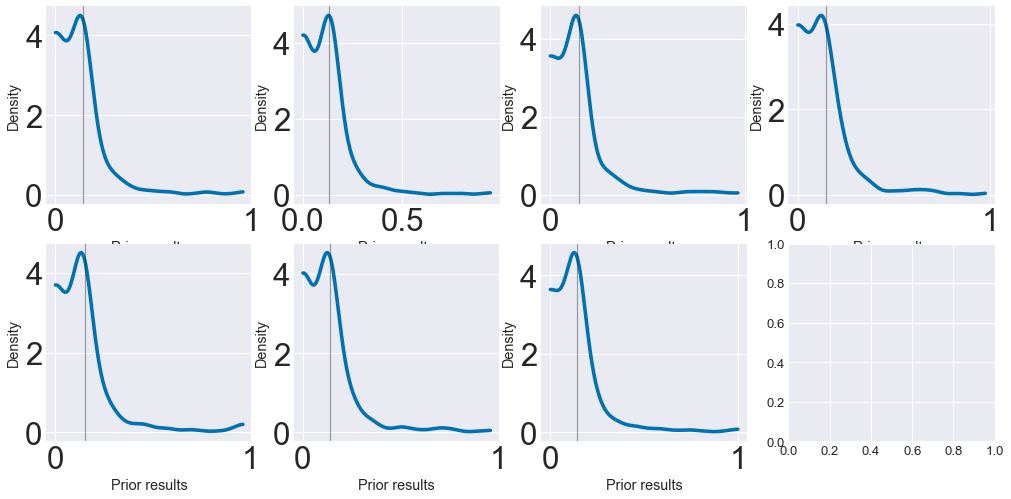

In [20]:
prior_p = softmax(prior_checks["a"][:, None] + prior_checks["a_dpt"], axis=2)[:, 11]
prior_pred_checks(prior_p)

In [21]:
with m_itcpt:
    trace_itcpt = pm.sample(1000, tune=3000, cores=2, random_seed=RANDOM_SEED)

az.summary(trace_itcpt, round_to=2, var_names=["a", "sigma_dpt"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_dpt, sigma_dpt, a]
Sampling 2 chains: 100%|██████████| 8000/8000 [2:14:44<00:00,  1.01s/draws]  


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-2.06,0.04,-2.13,-1.98,0.0,0.0,5970.72,5970.72,6012.83,1386.50,1.0
a[1],-1.33,0.04,-1.41,-1.24,0.0,0.0,6597.45,6597.45,6602.06,1051.85,1.0
a[2],-2.56,0.04,-2.64,-2.48,0.0,0.0,5437.86,5437.86,5470.59,1579.29,1.0
a[3],-1.83,0.04,-1.91,-1.75,0.0,0.0,6314.10,6288.37,6237.22,1409.14,1.0
a[4],-1.30,0.04,-1.37,-1.22,0.0,0.0,6239.16,6239.16,6193.39,1668.37,1.0
a[5],-1.93,0.04,-2.02,-1.85,0.0,0.0,6212.75,6212.75,6211.25,1517.23,1.0
a[6],-1.60,0.04,-1.68,-1.52,0.0,0.0,5603.24,5603.24,5564.70,1305.67,1.0
sigma_dpt,0.25,0.01,0.23,0.26,0.0,0.0,1358.80,1357.17,1356.75,1245.45,1.0


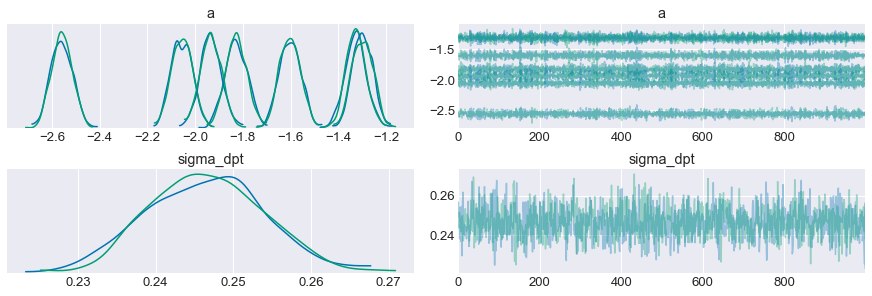

In [22]:
az.plot_trace(trace_itcpt, var_names=["a", "sigma_dpt"], compact=True)

The model ran smoothly and the chains look healthy, but sampling was very long. Is it because some parties sometimes get results that are very close to zero?

In [10]:
d[PARTIES].describe().round(2)

,farleft,left,green,center,right,farright,other
count,1889.00,1889.00,1889.00,1889.00,1889.00,1889.00,1889.00
mean,10.10,21.63,5.87,12.72,21.93,11.68,16.06
std,4.21,7.97,3.83,8.35,9.11,6.44,10.44
min,0.45,0.58,0.13,0.17,0.53,0.13,0.01
25%,6.95,15.88,3.15,6.82,15.33,6.86,8.13
50%,9.76,21.16,4.79,10.11,20.96,10.69,13.73
75%,12.81,26.94,7.65,17.82,27.45,15.38,22.08
max,32.84,50.36,27.46,44.47,56.33,40.02,75.43


In [22]:
cond = (
    (d.farleft >= 6.0)
    & (d.left >= 6.0)
    & (d.green >= 6.0)
    & (d.center >= 6.0)
    & (d.right >= 6.0)
    & (d.farright >= 6.0)
    & (d.other >= 6.0)
)
d2 = d.loc[cond]

In [28]:
dpt_id, dpts = d2.departement.factorize(sort=True)
Ndpts = len(dpts)
Nparties = len(PARTIES)
N = d2[PARTIES_INT].sum(axis=1).values
R_obs = d2[PARTIES_INT].values

with pm.Model() as m_itcpt_thresh:

    a = pm.Normal("a", -1.8, 0.1, shape=Nparties)
    sigma_dpt = pm.Exponential("sigma_dpt", 1.0)

    # one intercept for each dpt and each party:
    a_dpt = pm.Normal("a_dpt", 0.0, sigma_dpt, shape=(Ndpts, Nparties))
    print("a_dpt: ", a_dpt.tag.test_value.shape)

    p = tt.nnet.softmax(a + a_dpt[dpt_id])
    print("p: ", p.tag.test_value.shape)

    print("N: ", N.shape)
    print("R_obs: ", R_obs.shape)
    R = pm.Multinomial("R", n=N, p=p, observed=R_obs)

    trace_itcpt_thresh = pm.sample(1000, tune=3000, cores=2, random_seed=RANDOM_SEED)

az.summary(trace_itcpt_thresh, round_to=2, var_names=["a", "sigma_dpt"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-2.06,0.04,-2.13,-1.98,0.0,0.0,2729.31,2729.31,2740.74,1560.72,1.0
a[1],-1.40,0.04,-1.48,-1.33,0.0,0.0,2724.09,2722.41,2744.78,1510.64,1.0
a[2],-2.14,0.04,-2.22,-2.06,0.0,0.0,2865.19,2865.19,2844.78,1558.03,1.0
a[3],-1.99,0.04,-2.07,-1.92,0.0,0.0,2900.23,2900.23,2932.31,1466.56,1.0
a[4],-1.49,0.04,-1.57,-1.41,0.0,0.0,2961.24,2961.24,2944.73,1523.03,1.0
a[5],-1.89,0.04,-1.96,-1.80,0.0,0.0,2913.65,2913.65,2908.52,1669.07,1.0
a[6],-1.62,0.04,-1.69,-1.54,0.0,0.0,3002.59,3002.59,2995.94,1554.38,1.0
sigma_dpt,0.23,0.01,0.21,0.24,0.0,0.0,1954.38,1945.51,1957.76,1380.46,1.0


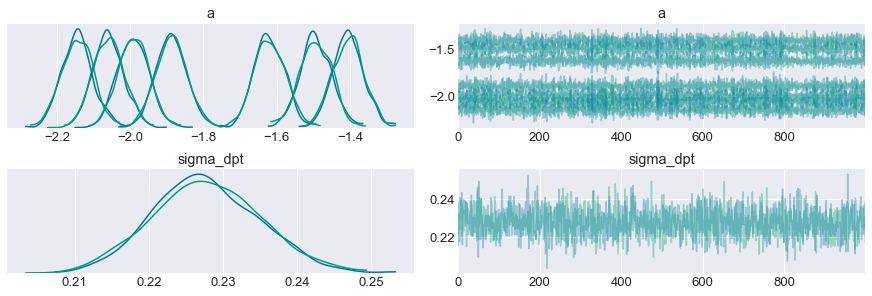

In [29]:
az.plot_trace(trace_itcpt_thresh, var_names=["a", "sigma_dpt"], compact=True)

Indeed, if we throw out the cases where any party has less than 6% of the votes, sampling gets notably faster. So it can be that results near 0 hurt sampling. Or it can also be that sampling is faster when there is less data!

Let's do another test. If we aggregate all parties into 3 fictional big parties, near-0 results virtually disapear, but the amount of data is the same as the original. So, if sampling is still slow, it means it's not because of the zeros:

In [4]:
d["big_left"] = d["farleft_int"] + d["left_int"] + d["green_int"]
d["big_right"] = d["farright_int"] + d["right_int"]
d["big_other"] = d["center_int"] + d["other_int"]

In [5]:
dpt_id, dpts = d.departement.factorize(sort=True)
Ndpts = len(dpts)
Nparties = 3
N = d[["big_left", "big_right", "big_other"]].sum(axis=1).values
R_obs = d[["big_left", "big_right", "big_other"]].values

with pm.Model() as m_itcpt_big:

    a = pm.Normal("a", -1.8, 0.1, shape=Nparties)
    sigma_dpt = pm.Exponential("sigma_dpt", 1.0)

    # one intercept for each dpt and each party:
    a_dpt = pm.Normal("a_dpt", 0.0, sigma_dpt, shape=(Ndpts, Nparties))
    print("a_dpt: ", a_dpt.tag.test_value.shape)

    p = tt.nnet.softmax(a + a_dpt[dpt_id])
    print("p: ", p.tag.test_value.shape)

    print("N: ", N.shape)
    print("R_obs: ", R_obs.shape)
    R = pm.Multinomial("R", n=N, p=p, observed=R_obs)

    trace_itcpt_big = pm.sample(1000, tune=3000, cores=2, random_seed=RANDOM_SEED)

az.summary(trace_itcpt_big, round_to=2, var_names=["a", "sigma_dpt"])

a_dpt:  (96, 3)
p:  (1889, 3)
N:  (1889,)
R_obs:  (1889, 3)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_dpt, sigma_dpt, a]
Sampling 2 chains: 100%|██████████| 8000/8000 [1:18:31<00:00,  1.70draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.68,0.06,-1.80,-1.57,0.0,0.0,5144.30,5043.80,5173.72,1349.86,1.0
a[1],-1.78,0.06,-1.90,-1.68,0.0,0.0,5748.60,5596.83,5845.63,1414.06,1.0
a[2],-1.94,0.06,-2.05,-1.83,0.0,0.0,5943.91,5808.23,6059.38,1343.08,1.0
sigma_dpt,0.19,0.01,0.17,0.21,0.0,0.0,1162.86,1161.34,1164.79,1451.68,1.0


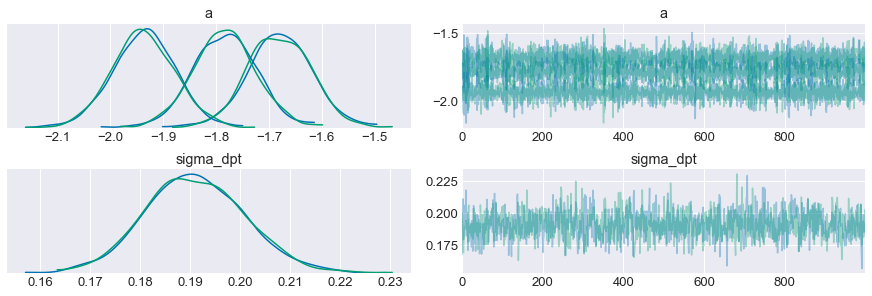

In [7]:
az.plot_trace(trace_itcpt_big, var_names=["a", "sigma_dpt"], compact=True)

And indeed, sampling is still slow, although it's a little better than at the beginning. This suggests that less zeros helps but it's not the only factor: the amount of data seems to play a bigger role.

Let's test this hypothesis by analyzing only recent elections, which reduces the number of rows in the dataframe:

In [17]:
d2 = d.loc[d.date >= "2007"]

dpt_id, dpts = d2.departement.factorize(sort=True)
Ndpts = len(dpts)
Nparties = len(PARTIES)
N = d2[PARTIES_INT].sum(axis=1).values
R_obs = d2[PARTIES_INT].values

with pm.Model() as m_itcpt_reduced:

    a = pm.Normal("a", -1.8, 0.1, shape=Nparties)
    sigma_dpt = pm.Exponential("sigma_dpt", 1.0)

    # one intercept for each dpt and each party:
    a_dpt = pm.Normal("a_dpt", 0.0, sigma_dpt, shape=(Ndpts, Nparties))
    print("a_dpt: ", a_dpt.tag.test_value.shape)

    p = tt.nnet.softmax(a + a_dpt[dpt_id])
    print("p: ", p.tag.test_value.shape)

    print("N: ", N.shape)
    print("R_obs: ", R_obs.shape)
    R = pm.Multinomial("R", n=N, p=p, observed=R_obs)

    trace_itcpt_reduced = pm.sample(1000, tune=3000, cores=2, random_seed=RANDOM_SEED)

az.summary(trace_itcpt_reduced, round_to=2, var_names=["a", "sigma_dpt"])

a_dpt:  (96, 7)
p:  (721, 7)
N:  (721,)
R_obs:  (721, 7)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_dpt, sigma_dpt, a]
Sampling 2 chains: 100%|██████████| 8000/8000 [41:31<00:00,  3.21draws/s]  


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-2.12,0.04,-2.20,-2.03,0.0,0.0,5190.84,5186.13,5227.57,1533.54,1.00
a[1],-1.31,0.04,-1.39,-1.23,0.0,0.0,5595.59,5502.19,5615.96,1611.56,1.00
a[2],-2.43,0.05,-2.52,-2.35,0.0,0.0,5263.48,5261.20,5257.10,1457.73,1.00
a[3],-1.86,0.04,-1.95,-1.78,0.0,0.0,4912.12,4888.28,4896.02,1401.94,1.01
a[4],-1.07,0.04,-1.16,-0.99,0.0,0.0,5224.18,5119.14,5208.69,1302.70,1.00
a[5],-1.85,0.04,-1.94,-1.77,0.0,0.0,5009.86,5009.86,4965.86,1571.13,1.00
a[6],-1.95,0.04,-2.03,-1.86,0.0,0.0,5571.27,5563.71,5518.03,1382.70,1.00
sigma_dpt,0.24,0.01,0.23,0.26,0.0,0.0,1666.03,1663.69,1672.30,1575.62,1.00


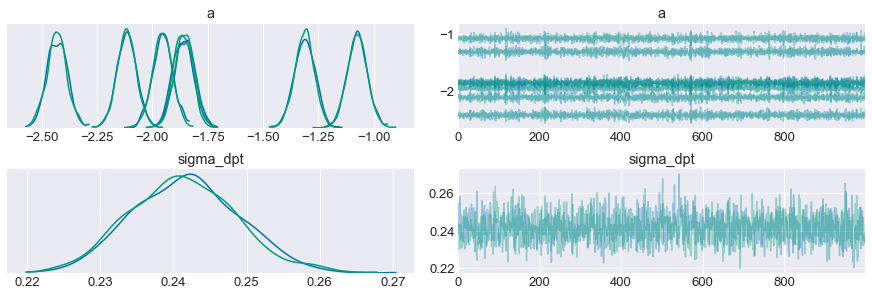

In [18]:
az.plot_trace(trace_itcpt_reduced, var_names=["a", "sigma_dpt"], compact=True)

Bingpot! Reducing the number of rows in the dataframe (here taking only recent elections) does seem to speed-up sampling. This would suggest the parties spending some time near zero only mildly hurt sampling - the amount of data seems to play a bigger role.

**But how can we improve that?**

In any case, we can already improve the model by telling it to be super skeptical of election results < 2.5% for any party - by definition, the parties we analyze here are big players. In other words, we wanna ensure all parties have a non-null probability. We use `pm.Potential` to do that:

In [54]:
# tester avec pm.Potential
dpt_id, dpts = d.departement.factorize(sort=True)
Ndpts = len(dpts)
Nparties = len(PARTIES)
N = d[PARTIES_INT].sum(axis=1).values
R_obs = d[PARTIES_INT].values

with pm.Model() as m_itcpt_pot:

    a = pm.Normal("a", -1.8, 0.1, shape=Nparties)
    sigma_dpt = pm.Exponential("sigma_dpt", 1.0)

    # one intercept for each dpt and each party:
    a_dpt = pm.Normal("a_dpt", 0.0, sigma_dpt, shape=(Ndpts, Nparties))
    print("a_dpt: ", a_dpt.tag.test_value.shape)

    p = tt.nnet.softmax(a + a_dpt[dpt_id])
    print("p: ", p.tag.test_value.shape)
    # ensure all parties have non-null probability:
    p_min = pm.Potential("p_min", tt.switch(tt.min(p, axis=1) < 0.025, -np.inf, 0))
    print("p_min: ", p_min.tag.test_value.shape)

    print("N: ", N.shape)
    print("R_obs: ", R_obs.shape)
    R = pm.Multinomial("R", n=N, p=p, observed=R_obs)

    trace_itcpt_pot = pm.sample(1000, tune=3000, cores=2, random_seed=RANDOM_SEED)

az.summary(trace_itcpt_pot, round_to=2, var_names=["a", "sigma_dpt"])

a_dpt:  (96, 7)
p:  (1889, 7)
p_min:  (1889,)
N:  (1889,)
R_obs:  (1889, 7)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_dpt, sigma_dpt, a]
Sampling 2 chains:   0%|          | 0/8000 [00:00<?, ?draws/s]/anaconda/envs/fund/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda/envs/fund/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling 2 chains:   0%|          | 0/8000 [00:04<?, ?draws/s]
Bad initial energy, check any log probabilities that are inf or -inf, nan or very small:
Series([], )


ParallelSamplingError: Bad initial energy

In [ ]:
with pm.Model() as hier_model:
    
    sigma_dpt_interp = pm.HalfNormal('sigma_dpt_interp', 10.)
    sigma_fixed = pm.HalfNormal('sigma_fixed', 10.)
    sigma_random = pm.HalfNormal('sigma_random', 10.)
    
    dpt_interp = pm.Normal('dpt_interp', 0., sigma_dpt_interp, shape=(n_dptmts, n_parties-1))
    print('dpt_interp: ', dpt_interp.tag.test_value.shape)
    
    fixed_effect = pm.Normal('fixed_effect', 0., sigma_fixed, shape=(n_regressors-1, n_parties-1))
    print('fixed_effect: ', fixed_effect.tag.test_value.shape)
    
    random_effect = pm.Normal('random_effect', 0., sigma_random, shape=n_parties-1)
    print('random_effect: ', random_effect.tag.test_value.shape)
    
    results_est = dpt_interp[dptmts_idx]\ # intercept: one for each dpt and each party
                    + tt.dot(groupX, fixed_effect)[date_idx]\ # effet fixe sur l'ensemble du pays des prédicteurs nationaux
                    + X_full['chomage'].values[:, None] * random_effect # effet varié du chômage sur chacun des dpts
    results_est = tt.concatenate(tensor_list=[results_est, 
                                              tt.zeros((X_full.shape[0], 1))], 
                                 axis=1)
    print('results_est: ', results_est.tag.test_value.shape)
    
    probs = pm.Deterministic('probs', tt.nnet.softmax(results_est))
    print('probs: ', probs.tag.test_value.shape)
    likelihood = pm.Multinomial('likelihood',
                                n=y_full.sum(axis=1),
                                p=probs,
                                observed=y_full.values)
    
    # might need to increase tunning
    trace = pm.sample(1000, tune=2000, cores=4, random_seed=RANDOM_SEED)

# pour analyser toutes les élections, y compris celles où des partis sont absents: zero-inflated mixture process? (cf. Rethinking2, lecture 13 & chapter 12)